In [1]:
from astropalmerio.mc import utils
from astropalmerio.mc.drawings import sample_asym_norm
from astropalmerio.mc.realizations import MC_realization
from astropalmerio.mc.MC_var import MC_var
from astropalmerio.mc.utils import unbinned_empirical_cdf, binned_CDFs_from_realizations, quantiles
from astropalmerio.mc.visualization import plot_CDF_with_bounds, plot_ECDF

from astropalmerio.mc.visualization import add_arrows_for_limits

import cmasher as cmr

import time
import logging
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import sys
from pathlib import Path
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)
ROOT_DIR = Path('/Users/palmerio/Code_projects/astropalmerio/dev/')
plt.style.use('paper')
plt.style.use('kraken')

## Practical example: propagating the individual measurement uncertainty to the CDF of an observed sample
In the physical sciences, it is often the case that we want to look at the distribution of a certain quantity for various samples, in order to compare them with each other.
How do we then propagate the uncertainty on the measurement of this quantity for each individual object in our sample to the whole sample distribution?
This can be done with Monte Carlo sampling/error propagation, as will be shown below.


For this example, let us assume we are looking at the distribution of stellar masses ($M_*$) of a sample of star-forming galaxies.
We would like to know the uncertainty on the cumulative distribution function of this sample.


## Standard case

2023-01-28 20:07:27,976 INFO [__main__] Starting MC realizations...
2023-01-28 20:07:27,979 INFO [__main__] Finished in 1.45e-03 seconds
2023-01-28 20:07:27,979 INFO [__main__] Starting MC realizations through MC_var class...
2023-01-28 20:07:27,981 INFO [__main__] Finished in 1.65e-03 seconds
2023-01-28 20:07:28,026 INFO [__main__] Plotting individual MC realizations of the CDF...
2023-01-28 20:07:29,427 INFO [__main__] Finished in 1.40e+00 seconds
2023-01-28 20:07:29,428 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-01-28 20:07:29,547 INFO [__main__] Finished in 1.18e-01 seconds
2023-01-28 20:07:29,559 INFO [__main__] Plotting individual PDFs using MC_var class method...
2023-01-28 20:07:33,453 INFO [__main__] Finished in 3.89e+00 seconds
2023-01-28 20:07:33,455 INFO [__main__] Plotting individual realizations histograms using MC_var class method...
2023-01-28 20:07:37,226 INFO [__main__] Finished in 3.77e+00 seconds


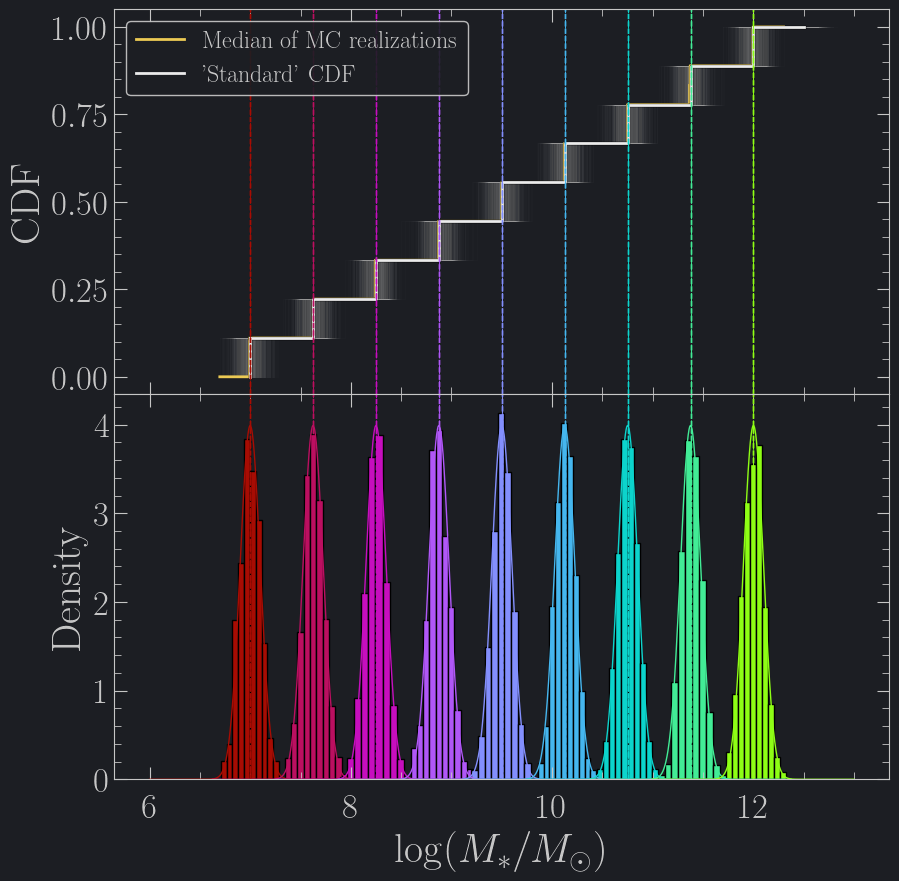

In [6]:
np.random.seed(0)  # To allow reproducibility

N_MC = 1000    # Number of Monte Carlo realizations
N_gal = 9      # Size of our sample (i.e. number of galaxies)
abs_err = 0.1  # absolute error value

logMstar = np.linspace(7, 12, N_gal)
logMstar_err = abs_err * np.ones(N_gal)

logging.getLogger('astropalmerio.mc.realizations').setLevel('INFO')

log.info("Starting MC realizations...")
t1 = time.time()
# For use of arrays instead of a single MC variable
logMstar_MC = MC_realization(data=logMstar,
                             errp=logMstar_err,
                             N_MC=N_MC)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Starting MC realizations through MC_var class...")
t1 = time.time()
# For ease of use of the plotting methods of the MC_var class
gals = []
for i in range(N_gal):
    gal = MC_var(value=logMstar[i], error=logMstar_err[i], N_MC=N_MC)
    gal.sample()
    gals.append(gal)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")
   

colors = cmr.take_cmap_colors('cmr.neon', N_gal, cmap_range=(0.0, 1), return_fmt='hex')

fig, axes = plt.subplots(2,figsize=(10,10), sharex=True)
ax = axes[1]
ax_CDF = axes[0]

# CDFs
log.info("Plotting individual MC realizations of the CDF...")
t1 = time.time()
for i in range(min(N_MC, 1000)):
    plot_ECDF(logMstar_MC[i], ax=ax_CDF, lw=1, color='C12', alpha=0.01)

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Computing and plotting median CDF and its bounds...")
t1 = time.time()
bins, CDFs = binned_CDFs_from_realizations(logMstar_MC)
med, upp, low = quantiles(CDFs)
ax_CDF.plot(0.5*(bins[1:]+bins[:-1]), med,
            drawstyle="steps-mid",
            lw=2,
            color='C9',
            label='Median of MC realizations')

# plot_CDF_with_bounds(bins_mid=0.5*(bins[1:]+bins[:-1]),
#                      median=med,
#                      upper=upp,
#                      lower=low,
#                      ax=ax_CDF,
#                      lw=2,
#                      color='C9',
#                      alpha=0.5,
#                      label='Median of MC realizations')

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")


# Classical CDF
plot_ECDF(logMstar, ax=ax_CDF, lw=2.5, color='black')
plot_ECDF(logMstar, ax=ax_CDF, lw=2, color='C12', label="'Standard' CDF")

ax_CDF.legend(loc='upper left')

# Individual PDFs
log.info("Plotting individual PDFs using MC_var class method...")
t1 = time.time()
for i, gal in enumerate(gals):
    gal.show_pdf(ax=ax, color=colors[i], lw=1)
    ax.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Plotting individual realizations histograms using MC_var class method...")
t1 = time.time()
for i, gal in enumerate(gals):
    gal.show_realizations(ax=ax, density=True, color=colors[i])
    ax.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

for i, gal in enumerate(gals):
    ax.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])

ax_CDF.set_ylabel('CDF')
ax.set_ylabel('Density')
ax.set_xlabel(r'$\log(M_*/M_{\odot})$')
fig.subplots_adjust(hspace=0)
plt.show()

In [7]:
fig.savefig('../plots/CDF_standard_example.pdf')

## Case with large errors (30% relative error)

2023-01-28 20:27:00,420 INFO [__main__] Starting MC realizations...
2023-01-28 20:27:00,426 INFO [__main__] Finished in 5.29e-03 seconds
2023-01-28 20:27:00,427 INFO [__main__] Starting MC realizations through MC_var class...
2023-01-28 20:27:00,429 INFO [__main__] Finished in 1.79e-03 seconds
2023-01-28 20:27:00,457 INFO [__main__] Plotting individual MC realizations of the CDF...
2023-01-28 20:27:01,985 INFO [__main__] Finished in 1.53e+00 seconds
2023-01-28 20:27:01,986 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-01-28 20:27:02,108 INFO [__main__] Finished in 1.21e-01 seconds
2023-01-28 20:27:02,120 INFO [__main__] Plotting individual PDFs using MC_var class method...
2023-01-28 20:27:05,839 INFO [__main__] Finished in 3.72e+00 seconds


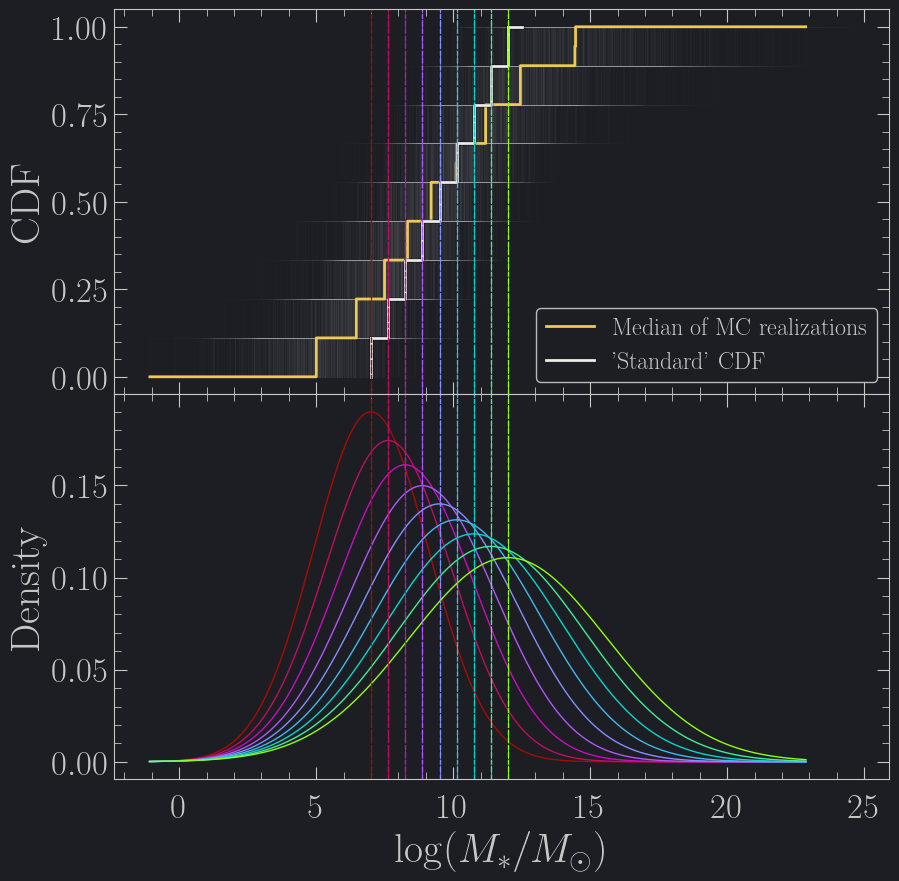

In [15]:
np.random.seed(0)  # To allow reproducibility

N_MC = 1000    # Number of Monte Carlo realizations
N_gal = 9      # Size of our sample (i.e. number of galaxies)
rel_err = 0.3  # absolute error value

logMstar = np.linspace(7, 12, N_gal)
logMstar_err = rel_err * logMstar
np.random.seed(0)  # To allow reproducibility

logging.getLogger('astropalmerio.mc.realizations').setLevel('INFO')

log.info("Starting MC realizations...")
t1 = time.time()
# For use of arrays instead of a single MC variable
logMstar_MC = MC_realization(data=logMstar,
                             errp=logMstar_err,
                             N_MC=N_MC)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Starting MC realizations through MC_var class...")
t1 = time.time()
# For ease of use of the plotting methods of the MC_var class
gals = []
for i in range(N_gal):
    gal = MC_var(value=logMstar[i], error=logMstar_err[i], N_MC=N_MC)
    gal.sample()
    gals.append(gal)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")
   

colors = cmr.take_cmap_colors('cmr.neon', N_gal, cmap_range=(0.0, 1), return_fmt='hex')

fig, axes = plt.subplots(2,figsize=(10,10), sharex=True)
ax = axes[1]
ax_CDF = axes[0]

# CDFs
log.info("Plotting individual MC realizations of the CDF...")
t1 = time.time()
for i in range(min(N_MC, 1000)):
    plot_ECDF(logMstar_MC[i], ax=ax_CDF, lw=1, alpha=0.01, color='C12')

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Computing and plotting median CDF and its bounds...")
t1 = time.time()
bins, CDFs = binned_CDFs_from_realizations(logMstar_MC)
med, upp, low = quantiles(CDFs)
ax_CDF.plot(0.5*(bins[1:]+bins[:-1]), med,
            drawstyle="steps-mid",
            lw=2,
            color='C9',
            label='Median of MC realizations')
# plot_CDF_with_bounds(bins_mid=0.5*(bins[1:]+bins[:-1]),
#                      median=med,
#                      upper=upp,
#                      lower=low,
#                      ax=ax_CDF,
#                      lw=2,
#                      color='C9',
#                      alpha=0.5,
#                      label='Median of MC realizations')

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")


# Classical CDF
plot_ECDF(logMstar, ax=ax_CDF, lw=2.5, color='black')
plot_ECDF(logMstar, ax=ax_CDF, lw=2, color='C12', label="'Standard' CDF")

ax_CDF.legend(loc='lower right')

# Individual PDFs
log.info("Plotting individual PDFs using MC_var class method...")
t1 = time.time()
x = np.linspace(logMstar_MC.min(), logMstar_MC.max(), 1000)
for i, gal in enumerate(gals):
    gal.show_pdf(x=x, ax=ax, color=colors[i], lw=1)
    ax.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

for i, gal in enumerate(gals):
    ax.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])

ax_CDF.set_ylabel('CDF')
ax.set_ylabel('Density')
ax.set_xlabel(r'$\log(M_*/M_{\odot})$')
fig.subplots_adjust(hspace=0)
plt.show()

In [ ]:
fig.savefig('../plots/CDF_large_error_example.pdf')

## Adding some values with limits

In [10]:
np.random.seed(0)  # To allow reproducibility

N_MC = 1000    # Number of Monte Carlo realizations
N_gal = 9      # Size of our sample (i.e. number of galaxies)

logMstar = np.linspace(7, 12, N_gal)
uplims = np.array([False for i in range(N_gal)])
# assume measurements number 4 and 5 are upper limits
uplims[[3,4]] = True
lolims = np.array([False for i in range(N_gal)])
# assume final measurement is a lower limit
lolims[-1] = True
val_min = np.where(uplims, 5, None)           # minimum value allowed in case of upper limits
val_max = np.where(lolims, 15, None)           # maximum value allowed in case of lower limits
logMstar_err = np.where(lolims|uplims, None, 0.1 * logMstar)
logMstar_err

array([0.7000000000000001, 0.7625000000000001, 0.8250000000000001, None,
       None, 1.0125, 1.075, 1.1375, None], dtype=object)

2023-01-28 20:07:48,329 INFO [__main__] Starting MC realizations...
2023-01-28 20:07:48,332 INFO [__main__] Finished in 2.27e-03 seconds
2023-01-28 20:07:48,332 INFO [__main__] Starting MC realizations through MC_var class...
2023-01-28 20:07:48,335 INFO [__main__] Finished in 1.64e-03 seconds
2023-01-28 20:07:48,363 INFO [__main__] Plotting individual MC realizations of the CDF...
2023-01-28 20:07:49,792 INFO [__main__] Finished in 1.43e+00 seconds
2023-01-28 20:07:49,793 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-01-28 20:07:49,908 INFO [__main__] Finished in 1.15e-01 seconds
2023-01-28 20:07:49,920 INFO [__main__] Plotting individual PDFs using MC_var class method...
2023-01-28 20:07:53,161 INFO [__main__] Finished in 3.24e+00 seconds


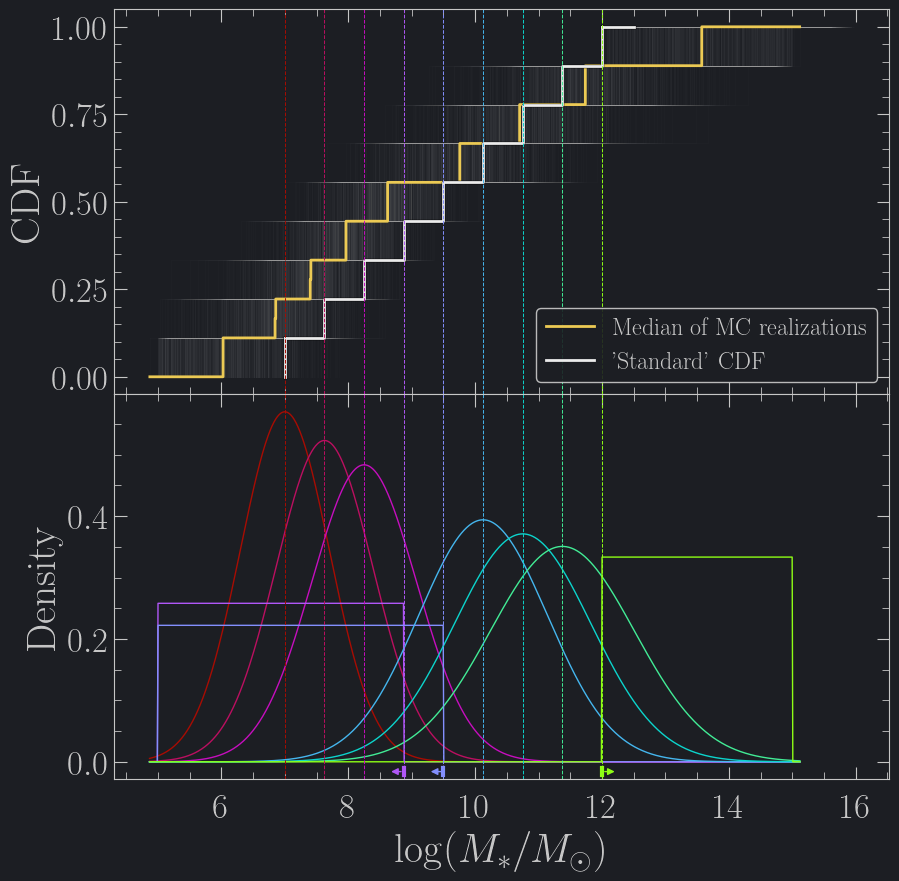

In [11]:
np.random.seed(0)  # To allow reproducibility

logging.getLogger('astropalmerio.mc.visualization').setLevel('DEBUG')

log.info("Starting MC realizations...")
t1 = time.time()
# For use of arrays instead of a single MC variable
logMstar_MC = MC_realization(data=logMstar,
                             errp=logMstar_err,
                             uplim=uplims,
                             lolim=lolims,
                             val_max=val_max,
                             val_min=val_min,
                             N_MC=N_MC)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Starting MC realizations through MC_var class...")
t1 = time.time()
# For ease of use of the plotting methods of the MC_var class
gals = []
for i in range(N_gal):
    gal = MC_var(value=logMstar[i],
                 error=logMstar_err[i],
                 uplim=uplims[i],
                 val_min=val_min[i],
                 lolim=lolims[i],
                 val_max=val_max[i],
                 N_MC=N_MC)
    gal.sample()
    gals.append(gal)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")
   

colors = cmr.take_cmap_colors('cmr.neon', N_gal, cmap_range=(0.0, 1), return_fmt='hex')

fig, axes = plt.subplots(2,figsize=(10,10), sharex=True)
ax = axes[1]
ax_CDF = axes[0]

# CDFs
log.info("Plotting individual MC realizations of the CDF...")
t1 = time.time()
for i in range(min(N_MC, 1000)):
    plot_ECDF(logMstar_MC[i], ax=ax_CDF, lw=1, alpha=0.01, color='C12')

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Computing and plotting median CDF and its bounds...")
t1 = time.time()
bins, CDFs = binned_CDFs_from_realizations(logMstar_MC)
med, upp, low = quantiles(CDFs)
ax_CDF.plot(0.5*(bins[1:]+bins[:-1]), med,
            drawstyle="steps-mid",
            lw=2,
            color='C9',
            label='Median of MC realizations')

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")


# Classical CDF
plot_ECDF(logMstar, ax=ax_CDF, lw=2.5, color='black')
plot_ECDF(logMstar, ax=ax_CDF, lw=2, color='C12', label="'Standard' CDF")

ax_CDF.legend(loc='lower right')

# Individual PDFs
log.info("Plotting individual PDFs using MC_var class method...")
t1 = time.time()
x = np.linspace(logMstar_MC.min(), logMstar_MC.max(), 1000)
for i, gal in enumerate(gals):
    gal.show_pdf(x=x, ax=ax, color=colors[i], lw=1)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

for i, gal in enumerate(gals):
    ax.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])
    if gal.lim['upper']:
        add_arrows_for_limits(logMstar[i], lim_type='upper', ax=ax, logscale=False, color=colors[i])    
    elif gal.lim['lower']:
        add_arrows_for_limits(logMstar[i], lim_type='lower', ax=ax, logscale=False, color=colors[i])    

# ax.set_xscale('log')
ax_CDF.set_ylabel('CDF')
ax.set_ylabel('Density')
ax.set_xlabel(r'$\log(M_*/M_{\odot})$')
fig.subplots_adjust(hspace=0)
plt.show()

In [12]:
fig.savefig('../plots/CDF_with_limits_example.pdf')

## Impact of sample size versus error size

2023-01-30 13:39:41,181 INFO [__main__] Starting MC realizations for N_gal=9...
2023-01-30 13:39:41,189 INFO [__main__] Finished in 6.57e-03 seconds
2023-01-30 13:39:41,189 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-01-30 13:39:42,258 INFO [__main__] Finished in 1.07e+00 seconds
2023-01-30 13:39:42,263 INFO [__main__] Starting MC realizations for N_gal=90...
2023-01-30 13:39:42,301 INFO [__main__] Finished in 3.74e-02 seconds
2023-01-30 13:39:42,302 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-01-30 13:39:43,509 INFO [__main__] Finished in 1.21e+00 seconds
2023-01-30 13:39:43,514 INFO [__main__] Starting MC realizations for N_gal=900...
2023-01-30 13:39:43,820 INFO [__main__] Finished in 3.06e-01 seconds
2023-01-30 13:39:43,821 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-01-30 13:39:45,496 INFO [__main__] Finished in 1.68e+00 seconds
2023-01-30 13:39:45,502 INFO [__main__] Starting MC realizations fo

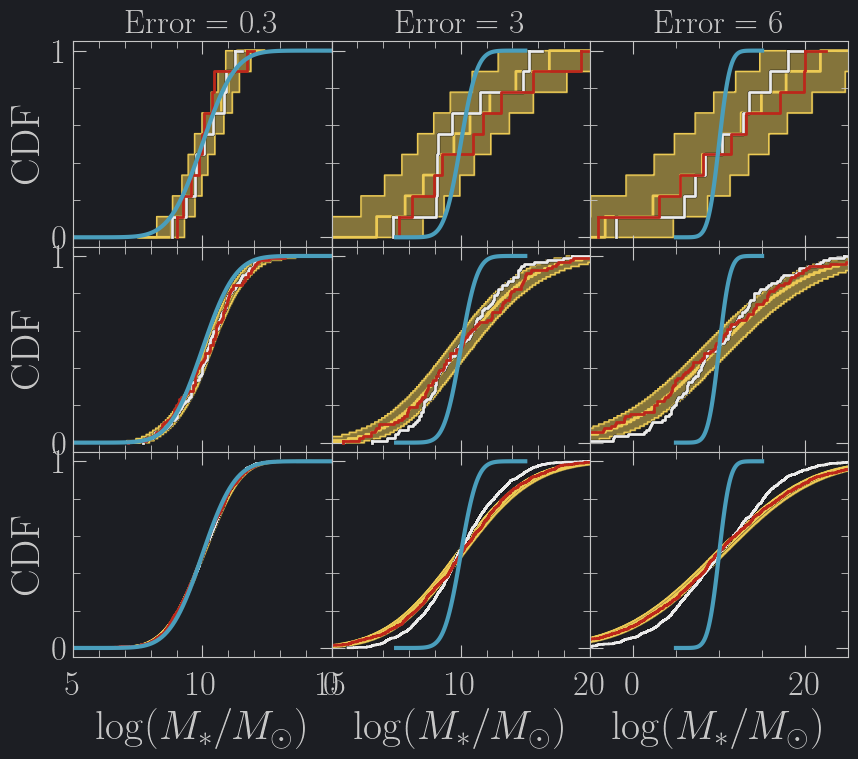

In [10]:
np.random.seed(10)  # To allow reproducibility

N_MC = 10000    # Number of Monte Carlo realizations
N_gals = [9, 90, 900]      
errs = [0.3, 3, 6]
fig, axes = plt.subplots(len(N_gals), len(errs), sharex='col')

for i in range(len(errs)):
    for ax, N_gal in zip(axes.T[i], N_gals):
        # Draw the values from a gaussian distribution
        logMstar = np.random.normal(10, 1, N_gal)
        # Add some random error
        logMstar = logMstar + np.random.normal(0, errs[i], N_gal)
        logMstar_err = errs[i] * np.ones(len(logMstar))

        log.info(f"Starting MC realizations for {N_gal=}...")
        t1 = time.time()
        # For use of arrays instead of a single MC variable
        logMstar_MC = MC_realization(data=logMstar,
                                     errp=logMstar_err,
                                     N_MC=N_MC)

        logMstar_true = logMstar_MC[0]

        t2 = time.time()
        log.info(f"Finished in {t2-t1:.2e} seconds")

        log.info("Computing and plotting median CDF and its bounds...")
        t1 = time.time()
        bins, CDFs = binned_CDFs_from_realizations(logMstar_MC)
        med, upp, low = quantiles(CDFs)
        plot_CDF_with_bounds(bins_mid=0.5*(bins[1:]+bins[:-1]),
                             median=med,
                             upper=upp,
                             lower=low,
                             ax=ax,
                             lw=2,
                             color='C9',
                             alpha=0.5,
                             label='Median of MC realizations')
        t2 = time.time()
        log.info(f"Finished in {t2-t1:.2e} seconds")

        # Classical CDF
        plot_ECDF(logMstar, ax=ax, lw=2.5, color='black')
        plot_ECDF(logMstar, ax=ax, lw=2, color='C12', label="'Standard' CDF")
        plot_ECDF(logMstar_true, ax=ax, lw=2, color='C4')
        
        # True CDF
        x = np.linspace(5, 15, 100)
        ax.plot(x, norm.cdf(x, 10, 1), color='C0')

    axes[i,0].set_ylabel('CDF')
    axes[0,i].set_title(f'Error = {errs[i]}')
    axes[-1,i].set_xlabel(r'$\log(M_*/M_{\odot})$')

for i, ax in enumerate(axes[:,1:].flatten()):
    ax.tick_params(axis='y',labelleft=False)

axes[0,0].set_xlim(5,15)
axes[0,1].set_xlim(0,20)
axes[0,2].set_xlim(-5,25)
    
# axes[-1,-1].legend(loc='lower right')
fig.subplots_adjust(hspace=0, wspace=0)

plt.show()